# **HOMEWORK 1**
Build a classifier for fashion MNIST.

**1. Use exactly the same architectures (both densely connected layers and from convolutional layers) as the above MNIST** e.g., replace the dataset. Save the Jupyter Notebook in its original format and output a PDF file after training, testing, and validation. Make sure to write down how do they perform (training accuracny, testing accuracy).  
**2. Improve the architecture**. Experiment with different numbers of layers, size of layers, number of filters, size of filters. You are required to make those adjustment to get the highest accuracy. Watch out for overfitting -- we want the highest testing accuracy!
Please provide a PDF file of the result, the best test accuracy and the architecture (different numbers of layers, size of layers, number of filters, size of filters)


# Fashion MNIST

The MNIST dataset is not too demanding, let's try something a little more difficult - Fashion MNIST.

[LINK TO IMAGE](https://s3-eu-central-1.amazonaws.com/zalando-wp-zalando-research-production/2017/08/fashion-mnist-sprite.png)

Check out labels on [GitHub](https://github.com/zalandoresearch/fashion-mnist):

## Data loading and exploration

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# PyTorch TensorBoard support
# from torch.utils.tensorboard import SummaryWriter
# import torchvision
# import torchvision.transforms as transforms

import torchvision
import torchvision.transforms as transforms

from torchvision.datasets import FashionMNIST
import matplotlib.pyplot as plt
%matplotlib inline

from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn.functional as F

from PIL import Image
#import torchvision.transforms as T

c:\Users\pabie\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = FashionMNIST(root="data/", download=True, train = True, transform = transforms.ToTensor())
data_loader = torch.utils.data.DataLoader(data,
                                          batch_size=128,
                                          shuffle=True)

In [3]:
# labels from the FashionMNIST's Github repo
label_dict = {
 0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'
}

torch.Size([1, 28, 28]) 0
tensor([[[0.6510, 0.5961, 0.6196, 0.6196, 0.6275],
         [0.6235, 0.6000, 0.6157, 0.6196, 0.6353],
         [0.6196, 0.6078, 0.6353, 0.6196, 0.6275],
         [0.5961, 0.6275, 0.6196, 0.6314, 0.6275],
         [0.5765, 0.6431, 0.6078, 0.6471, 0.6314]]])
tensor(1.) tensor(0.)


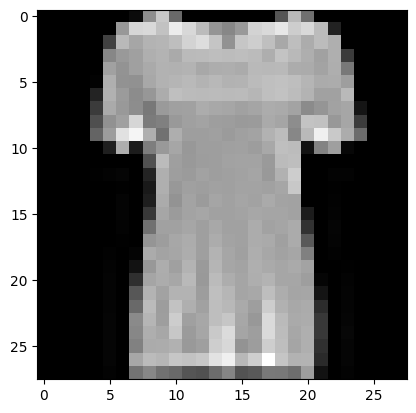

In [5]:
# mnist_dataset has 'images as tensors' so that they can't be displayed directly
sampleTensor, label = data[10]
print(sampleTensor.shape, label)
tpil = transforms.ToPILImage() # using the __call__ to
image = tpil(sampleTensor)
# image.show()

# The image is now convert to a 28 X 28 tensor.
# The first dimension is used to keep track of the color channels.
# Since images in the MNIST dataset are grayscale, there's just one channel.
# The values range from 0 to 1, with 0 representing black, 1 white and the values between different shades of grey.
print(sampleTensor[:,10:15,10:15])
print(torch.max(sampleTensor), torch.min(sampleTensor))
plt.imshow(sampleTensor[0,:,:],cmap = 'gray')

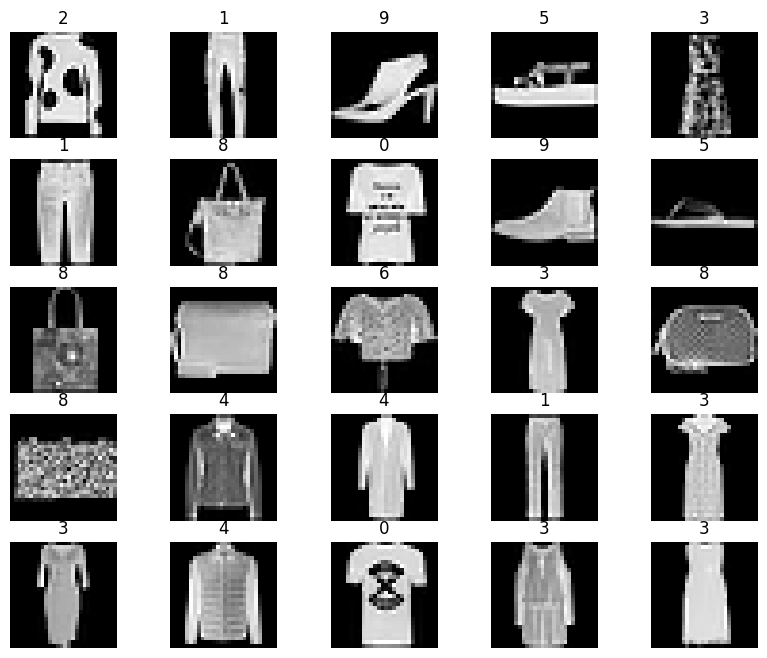

In [6]:
# Print multiple images at once
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(data), size=(1,)).item()
    img, label = data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

tensor([[[0.6510, 0.5961, 0.6196, 0.6196, 0.6275],
         [0.6235, 0.6000, 0.6157, 0.6196, 0.6353],
         [0.6196, 0.6078, 0.6353, 0.6196, 0.6275],
         [0.5961, 0.6275, 0.6196, 0.6314, 0.6275],
         [0.5765, 0.6431, 0.6078, 0.6471, 0.6314]]])
tensor(1.) tensor(0.)


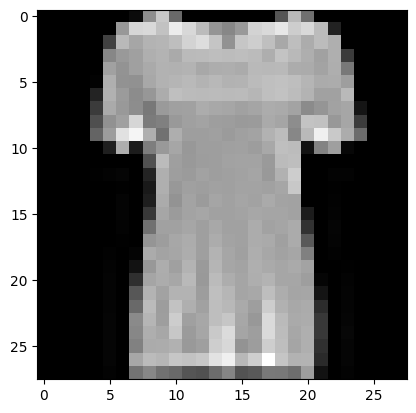

In [7]:
# The image is now convert to a 28 X 28 tensor.
# The first dimension is used to keep track of the color channels.
# Since images in the MNIST dataset are grayscale, there's just one channel.
# The values range from 0 to 1, with 0 representing black, 1 white and the values between different shades of grey.
print(sampleTensor[:,10:15,10:15])
print(torch.max(sampleTensor), torch.min(sampleTensor))
plt.imshow(sampleTensor[0,:,:],cmap = 'gray')

In [8]:
train_data, validation_data = random_split(data, [0.7, 0.3])
## Print the length of train and validation datasets
print("length of Train Datasets: ", len(train_data))
print("length of Validation Datasets: ", len(validation_data))

batch_size = 128
train_loader = DataLoader(train_data, batch_size, shuffle = True)
val_loader = DataLoader(validation_data, batch_size, shuffle = False)
## MNIST data from pytorch already provides held-out test set!

length of Train Datasets:  42000
length of Validation Datasets:  18000


## Multilogistic regression

### Simple model

In [9]:
input_size = 28 * 28
num_classes = 10

# accuracy calculation
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim = 1)
    return(torch.tensor(torch.sum(preds == labels).item()/ len(preds)))

class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return(out)

    # We add extra methods
    def training_step(self, batch):
        # when training, we compute the cross entropy, which help us update weights
        images, labels = batch
        out = self(images) ## Generate predictions
        loss = F.cross_entropy(out, labels) ## Calculate the loss
        return(loss)

    def validation_step(self, batch):
        images, labels = batch
        out = self(images) ## Generate predictions
        loss = F.cross_entropy(out, labels) ## Calculate the loss
        # in validation, we want to also look at the accuracy
        # idealy, we would like to save the model when the accuracy is the highest.
        acc = accuracy(out, labels) ## calculate metrics/accuracy
        return({'val_loss':loss, 'val_acc': acc})

    def validation_epoch_end(self, outputs):
        # at the end of epoch (after running through all the batches)
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return({'val_loss': epoch_loss.item(), 'val_acc' : epoch_acc.item()})

    def epoch_end(self, epoch,result):
        # log epoch, loss, metrics
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

# a simple helper function to evaluate
def evaluate(model, data_loader):
    # for batch in data_loader, run validation_step
    outputs = [model.validation_step(batch) for batch in data_loader]
    return(model.validation_epoch_end(outputs))

# actually training
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        ## Training Phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward() ## backpropagation starts at the loss and goes through all layers to model inputs
            optimizer.step() ## the optimizer iterate over all parameters (tensors); use their stored grad to update their values
            optimizer.zero_grad() ## reset gradients

        ## Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return(history)

In [10]:

# we instantiate the model
model = MnistModel()
print(model) # a very simple model

MnistModel(
  (linear): Linear(in_features=784, out_features=10, bias=True)
)


In [11]:
# test the functions, with a randomly initialized model (weights are random, e.g., untrained)
result0 = evaluate(model, val_loader)
result0

{'val_loss': 2.3336451053619385, 'val_acc': 0.04960106313228607}

In [12]:
# let's train for 10 epochs
history1 = fit(10, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.7901, val_acc: 0.5524
Epoch [1], val_loss: 1.5118, val_acc: 0.6483
Epoch [2], val_loss: 1.3392, val_acc: 0.6616
Epoch [3], val_loss: 1.2234, val_acc: 0.6704
Epoch [4], val_loss: 1.1416, val_acc: 0.6754
Epoch [5], val_loss: 1.0791, val_acc: 0.6831
Epoch [6], val_loss: 1.0309, val_acc: 0.6904
Epoch [7], val_loss: 0.9919, val_acc: 0.6973
Epoch [8], val_loss: 0.9597, val_acc: 0.7065
Epoch [9], val_loss: 0.9325, val_acc: 0.7136


Text(0.5, 1.0, 'Accuracy over epochs')

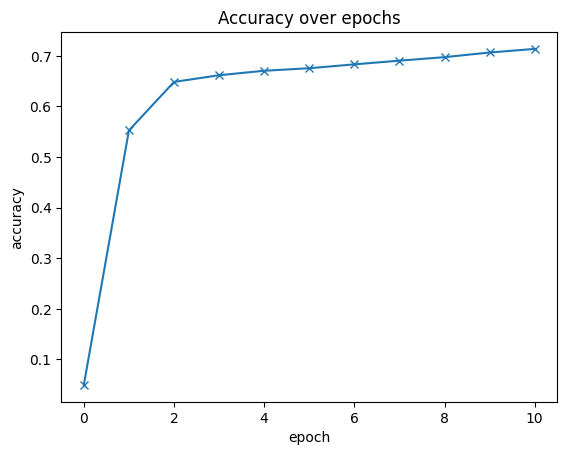

In [13]:
# plotting accuracy
history = [result0] + history1
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy over epochs')

Text(0.5, 1.0, 'Losses  over epochs')

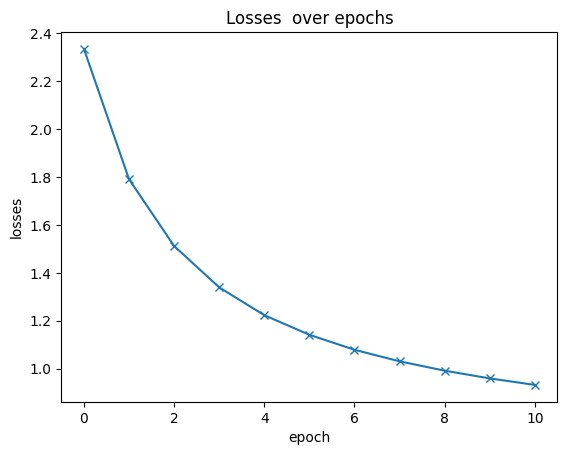

In [14]:
# plotting losses
history = [result0] + history1
losses = [result['val_loss'] for result in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.title('Losses  over epochs')

#### Tests

Length of Test Datasets:  10000
Shape:  torch.Size([1, 28, 28])
Label: Ankle boot (9)


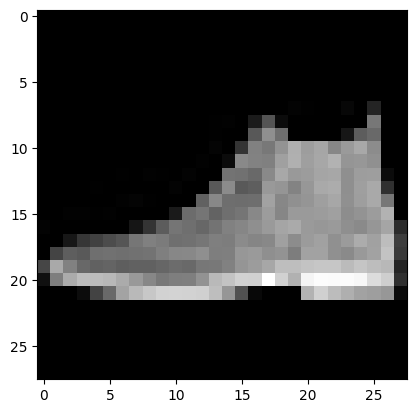

In [15]:
# Testing with individual images
## Define the test dataset
test_dataset = FashionMNIST(root = 'data/', train = False, transform = transforms.ToTensor())
print("Length of Test Datasets: ", len(test_dataset))
img, label = test_dataset[0]
plt.imshow(img[0], cmap = 'gray')
print("Shape: ", img.shape)
print(f'Label: {label_dict[label]} ({label})')

In [16]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds = torch.max(yb, dim = 1)
    return(preds[0].item())

In [17]:
img, label = test_dataset[0]
pred_label = predict_image(img, model)
print(f'Label: {label_dict[label]} ({label}), Predicted : {label_dict[pred_label]} ({pred_label})')

Label: Ankle boot (9), Predicted : Ankle boot (9)


In [18]:
# the final check on the test dataset (not used in any training)
test_loader = DataLoader(test_dataset, batch_size = 256, shuffle = False)
result = evaluate(model, test_loader)
result

{'val_loss': 0.9409843683242798, 'val_acc': 0.702343761920929}

### Improved model

In [117]:

class MnistModel(nn.Module):
    def __init__(self, input_size=784, hidden_sizes=[128], num_classes=10):
        super().__init__()
        # https://pytorch.org/docs/stable/generated/torch.nn.ModuleList.html
        # store layers in torch's list, more flexible for experimenting
        self.hidden_layers = nn.ModuleList()
        last_size = input_size

        for size in hidden_sizes:
            self.hidden_layers.append(nn.Linear(last_size, size))
            last_size = size

        self.output = nn.Linear(last_size, num_classes)

    def forward(self, xb):
        xb = xb.reshape(-1, 784) # flatten input
        for layer in self.hidden_layers:
            xb = F.relu(layer(xb))
        out = self.output(xb)
        return(out)

    # We add extra methods
    def training_step(self, batch):
        # when training, we compute the cross entropy, which help us update weights
        images, labels = batch
        out = self(images) ## Generate predictions
        loss = F.cross_entropy(out, labels) ## Calculate the loss
        return(loss)

    def validation_step(self, batch):
        images, labels = batch
        out = self(images) ## Generate predictions
        loss = F.cross_entropy(out, labels) ## Calculate the loss
        acc = accuracy(out, labels) ## calculate metrics/accuracy
        return({'val_loss':loss, 'val_acc': acc})

    def validation_epoch_end(self, outputs):
        # at the end of epoch (after running through all the batches)
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return({'val_loss': epoch_loss.item(), 'val_acc' : epoch_acc.item()})

    def epoch_end(self, epoch, result):
        # log epoch, loss, metrics
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))


def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.Adam):
    # different optimizer
    history = []
    optimizer = opt_func(model.parameters(), lr=lr)#, weight_decay=1e-5)
    for epoch in range(epochs):
        ## Training Phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward() ## backpropagation starts at the loss and goes through all layers to model inputs
            optimizer.step() ## the optimizer iterate over all parameters (tensors); use their stored grad to update their values
            optimizer.zero_grad() ## reset gradients

        ## Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return(history)

In [118]:

# we instantiate the model
model = MnistModel(hidden_sizes=[512, 256, 128, 64, 32])
print(model)


MnistModel(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): Linear(in_features=64, out_features=32, bias=True)
  )
  (output): Linear(in_features=32, out_features=10, bias=True)
)


In [119]:
# test the functions, with a randomly initialized model (weights are random, e.g., untrained)
result0 = evaluate(model, val_loader)
result0

{'val_loss': 2.305288791656494, 'val_acc': 0.10180629789829254}

In [120]:
# same number of epochs
# higher learning rate
history1 = fit(10, 0.01, model, train_loader, val_loader)

Epoch [0], val_loss: 0.5109, val_acc: 0.8232
Epoch [1], val_loss: 0.4356, val_acc: 0.8469
Epoch [2], val_loss: 0.4421, val_acc: 0.8493
Epoch [3], val_loss: 0.4823, val_acc: 0.8319
Epoch [4], val_loss: 0.4317, val_acc: 0.8550
Epoch [5], val_loss: 0.4340, val_acc: 0.8666
Epoch [6], val_loss: 0.4130, val_acc: 0.8640
Epoch [7], val_loss: 0.4066, val_acc: 0.8700
Epoch [8], val_loss: 0.3894, val_acc: 0.8745
Epoch [9], val_loss: 0.4084, val_acc: 0.8604


Text(0.5, 1.0, 'Accuracy over epochs')

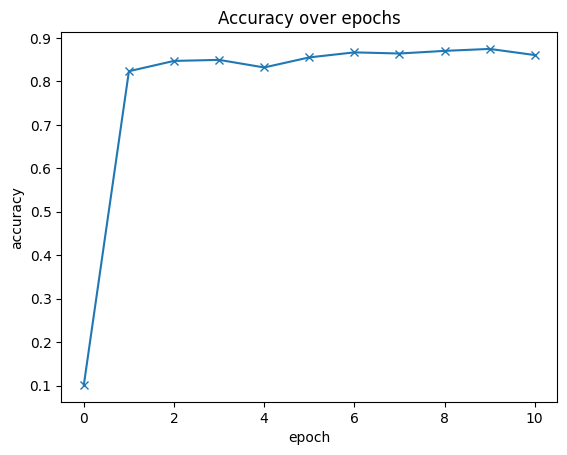

In [121]:
# plotting accuracy
history = [result0] + history1
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy over epochs')

Text(0.5, 1.0, 'Losses  over epochs')

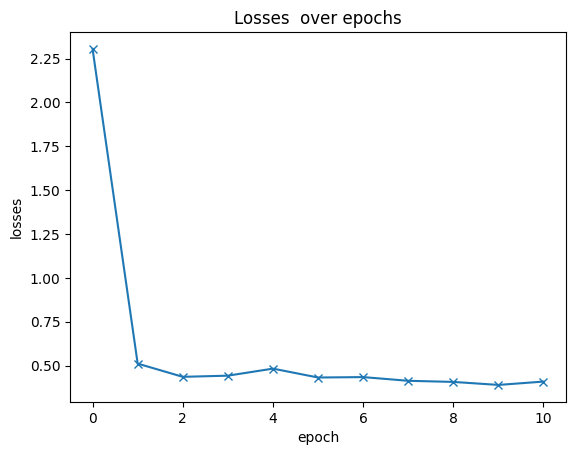

In [122]:
# plotting losses
history = [result0] + history1
losses = [result['val_loss'] for result in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.title('Losses  over epochs')

#### Tests

Length of Test Datasets:  10000
Shape:  torch.Size([1, 28, 28])
Label: Ankle boot (9)


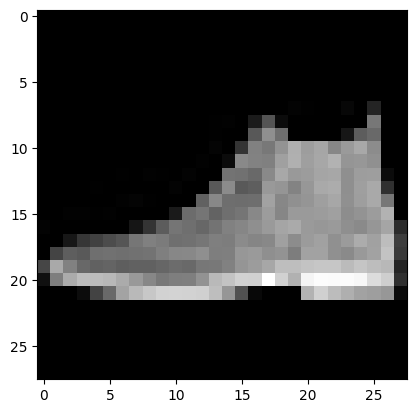

In [123]:
# Testing with individual images
## Define the test dataset
test_dataset = FashionMNIST(root = 'data/', train = False, transform = transforms.ToTensor())
print("Length of Test Datasets: ", len(test_dataset))
img, label = test_dataset[0]
plt.imshow(img[0], cmap = 'gray')
print("Shape: ", img.shape)
print(f'Label: {label_dict[label]} ({label})')

In [124]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds = torch.max(yb, dim = 1)
    return(preds[0].item())

In [125]:
img, label = test_dataset[0]
pred_label = predict_image(img, model)
print(f'Label: {label_dict[label]} ({label}), Predicted : {label_dict[pred_label]} ({pred_label})')

Label: Ankle boot (9), Predicted : Ankle boot (9)


In [126]:
# the final check on the test dataset (not used in any training)
test_loader = DataLoader(test_dataset, batch_size = 256, shuffle = False)
result = evaluate(model, test_loader)
result

# performance is a bit better than the simpler model

{'val_loss': 0.42414331436157227, 'val_acc': 0.852734386920929}

## Convolutional Neural Network (CNN)

### Simple model

In [127]:
# We construct a fundamental CNN class.
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output, x    # return x for visualization

cnn = CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


In [128]:
loss_func = nn.CrossEntropyLoss()
loss_func

# unlike earlier example using optim.SGD, we use optim.Adam as the optimizer
# lr(Learning Rate): Rate at which our model updates the weights in the cells each time back-propagation is done.
optimizer = optim.Adam(cnn.parameters(), lr = 0.01)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)

In [129]:

from torch.autograd import Variable

def train(num_epochs, cnn, loaders):
    cnn.train()
    optimizer = optim.Adam(cnn.parameters(), lr = 0.01)
    loss_func = nn.CrossEntropyLoss()
    # Train the model
    total_step = len(loaders)

    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders):

            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y
            output = cnn(b_x)[0]
            loss = loss_func(output, b_y)

            # clear gradients for this training step
            optimizer.zero_grad()

            # backpropagation, compute gradients
            loss.backward()
            # apply gradients
            optimizer.step()

            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
                pass
        pass
    pass

In [130]:
# instiate the CNN model
cnn = CNN()
# for testing purpose, we calculate the accuracy of the initial
cnn.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in train_loader:
        test_output, last_layer = cnn(images)
        pred_y = torch.max(test_output, 1)[1].data.squeeze()
        accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
        pass
print('Accuracy of the model on the 10000 test images: %.2f' % accuracy)


Accuracy of the model on the 10000 test images: 0.25


In [131]:
train(num_epochs=5, cnn=cnn, loaders=train_loader)

Epoch [1/5], Step [100/329], Loss: 0.4540
Epoch [1/5], Step [200/329], Loss: 0.2994
Epoch [1/5], Step [300/329], Loss: 0.2927
Epoch [2/5], Step [100/329], Loss: 0.4218
Epoch [2/5], Step [200/329], Loss: 0.3160
Epoch [2/5], Step [300/329], Loss: 0.4229
Epoch [3/5], Step [100/329], Loss: 0.2895
Epoch [3/5], Step [200/329], Loss: 0.2717
Epoch [3/5], Step [300/329], Loss: 0.2774
Epoch [4/5], Step [100/329], Loss: 0.3859
Epoch [4/5], Step [200/329], Loss: 0.4016
Epoch [4/5], Step [300/329], Loss: 0.3723
Epoch [5/5], Step [100/329], Loss: 0.3012
Epoch [5/5], Step [200/329], Loss: 0.2006
Epoch [5/5], Step [300/329], Loss: 0.2969


#### Tests

In [132]:
# Test the model, after the training
cnn.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in train_loader:
        test_output, last_layer = cnn(images)
        pred_y = torch.max(test_output, 1)[1].data.squeeze()
        accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
        pass
print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy)


Test Accuracy of the model on the 10000 test images: 0.88


In [133]:
# Test the model, after the training
cnn.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        test_output, last_layer = cnn(images)
        pred_y = torch.max(test_output, 1)[1].data.squeeze()
        accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
        pass
print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy)


Test Accuracy of the model on the 10000 test images: 0.94


In [134]:
sample = next(iter(test_loader))
imgs, lbls = sample

actual_number = lbls[:10].numpy()
actual_number

test_output, last_layer = cnn(imgs[:10])
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
print(f'Prediction number:   {pred_y}')
print(f'Actual number:       {actual_number}')

Prediction number:   [9 2 1 1 6 1 4 6 5 7]
Actual number:       [9 2 1 1 6 1 4 6 5 7]


### Improved model

In [201]:
# add one more conv layer
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            # nn.Dropout(p = 0.3)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            # nn.Dropout(p = 0.3)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            # nn.Dropout(p = 0.2)
        )
        # fully connected layer, output 10 classes
        # 
        self.out = nn.Linear(64 * 3 * 3, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output, x    # return x for visualization


def train(num_epochs, cnn, loaders):
    cnn.train()
    optimizer = optim.Adam(cnn.parameters(), lr = 0.01)
    loss_func = nn.CrossEntropyLoss()
    # Train the model
    total_step = len(loaders)

    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders):

            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y
            output = cnn(b_x)[0]
            loss = loss_func(output, b_y)

            # clear gradients for this training step
            optimizer.zero_grad()

            # backpropagation, compute gradients
            loss.backward()
            # apply gradients
            optimizer.step()

            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
                pass
        pass
    pass


cnn = CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=576, out_features=10, bias=True)
)


In [202]:
import torchsummary
# https://pypi.org/project/torch-summary/

print(torchsummary.summary(cnn, (1, 28, 28)))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 16, 14, 14]          --
|    └─Conv2d: 2-1                       [-1, 16, 28, 28]          416
|    └─ReLU: 2-2                         [-1, 16, 28, 28]          --
|    └─MaxPool2d: 2-3                    [-1, 16, 14, 14]          --
├─Sequential: 1-2                        [-1, 32, 7, 7]            --
|    └─Conv2d: 2-4                       [-1, 32, 14, 14]          12,832
|    └─ReLU: 2-5                         [-1, 32, 14, 14]          --
|    └─MaxPool2d: 2-6                    [-1, 32, 7, 7]            --
├─Sequential: 1-3                        [-1, 64, 3, 3]            --
|    └─Conv2d: 2-7                       [-1, 64, 7, 7]            51,264
|    └─ReLU: 2-8                         [-1, 64, 7, 7]            --
|    └─MaxPool2d: 2-9                    [-1, 64, 3, 3]            --
├─Linear: 1-4                            [-1, 10]                  5,770
Tot

In [203]:
# instiate the CNN model
cnn = CNN()
# for testing purpose, we calculate the accuracy of the initial
cnn.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in train_loader:
        test_output, last_layer = cnn(images)
        pred_y = torch.max(test_output, 1)[1].data.squeeze()
        accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
        pass
print('Accuracy of the model on the 10000 test images: %.2f' % accuracy)


Accuracy of the model on the 10000 test images: 0.12


In [204]:
train(num_epochs=10, cnn=cnn, loaders=train_loader)

Epoch [1/10], Step [100/329], Loss: 0.5551
Epoch [1/10], Step [200/329], Loss: 0.5450
Epoch [1/10], Step [300/329], Loss: 0.3549
Epoch [2/10], Step [100/329], Loss: 0.4997
Epoch [2/10], Step [200/329], Loss: 0.3133
Epoch [2/10], Step [300/329], Loss: 0.3168
Epoch [3/10], Step [100/329], Loss: 0.3379
Epoch [3/10], Step [200/329], Loss: 0.2088
Epoch [3/10], Step [300/329], Loss: 0.4101
Epoch [4/10], Step [100/329], Loss: 0.2873
Epoch [4/10], Step [200/329], Loss: 0.4078
Epoch [4/10], Step [300/329], Loss: 0.3233
Epoch [5/10], Step [100/329], Loss: 0.3374
Epoch [5/10], Step [200/329], Loss: 0.3229
Epoch [5/10], Step [300/329], Loss: 0.4476
Epoch [6/10], Step [100/329], Loss: 0.2440
Epoch [6/10], Step [200/329], Loss: 0.3497
Epoch [6/10], Step [300/329], Loss: 0.2610
Epoch [7/10], Step [100/329], Loss: 0.3618
Epoch [7/10], Step [200/329], Loss: 0.3212
Epoch [7/10], Step [300/329], Loss: 0.3287
Epoch [8/10], Step [100/329], Loss: 0.1977
Epoch [8/10], Step [200/329], Loss: 0.2862
Epoch [8/10

#### Tests

In [205]:
# Test the model, after the training
cnn.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in train_loader:
        test_output, last_layer = cnn(images)
        pred_y = torch.max(test_output, 1)[1].data.squeeze()
        accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
        pass
print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy)


Test Accuracy of the model on the 10000 test images: 0.94


In [206]:
# Test the model, after the training
cnn.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        test_output, last_layer = cnn(images)
        pred_y = torch.max(test_output, 1)[1].data.squeeze()
        accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
        pass
print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy)


Test Accuracy of the model on the 10000 test images: 0.88


In [207]:
sample = next(iter(test_loader))
imgs, lbls = sample

actual_number = lbls[:10].numpy()
actual_number

test_output, last_layer = cnn(imgs[:10])
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
print(f'Prediction number:   {pred_y}')
print(f'Actual number:       {actual_number}')

Prediction number:   [9 2 1 1 6 1 4 6 5 7]
Actual number:       [9 2 1 1 6 1 4 6 5 7]
